## Calculate Carbon Sequestration

In this notebook, carbon sequestration in the form of NPP is calculated from previuosly calculated and harmonized NIRv GPP. Then, the calculated NPP is further processed to retrieve spatially aggregated monthly mean values for Germany and federal states.

In [1]:
# import libraries
import glob
import os
import xarray as xr
import warnings
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
from pathlib import Path
import numpy as np

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# create list with forest types
forest_types = ("NL", "BL")

In [5]:
# apply NPP/GPP ratio to all monthly harmonized GPP datasets to calculate NPP for all pixels from 1981 - 2024
# process year-wise

for year in range(1981, 2025):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # open monthly GPP dataset of according year
        directory = "./GPP/GPP_NIRv/Monthly_harmonized/"
        file = glob.glob(os.path.join(directory, f"*{year}*{forest_type}*.nc"))

        gpp = xr.open_dataset(file[0])

        # calculate NPP from GPP
        npp = (gpp * 0.48).rename({"GPP": "NPP"})

        # add unit to variable attributes
        npp.NPP.attrs["units"] = "monthly mean of gC/m²/day"

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        npp.NPP.encoding.update(comp)

        # save created dataset as netCDF4 file
        npp.to_netcdf(f"./NPP/NPP_calc/Monthly/NPP_mon_mean_{year}_{forest_type}.nc")

In [6]:
# spatially aggregate monthly NPP data
# to get mean values for Germany and federal states

In [7]:
# first, get values for broadleaved forest
# load all monthly npp values as one dataset
directory = f"./NPP/NPP_calc/Monthly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
npp_monthly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [8]:
# calculate mean gpp values per month for Germany
npp_monthly_spatial_means = npp_monthly.mean(['lon','lat'], skipna=True).to_dataframe()
npp_monthly_spatial_means

,NPP,spatial_ref,crs
time,,,
1981-06-01,2.775910,0,-127
1981-07-01,2.382128,0,-127
1981-08-01,1.661157,0,-127
1981-09-01,1.743727,0,-127
1981-10-01,1.116664,0,-127
...,...,...,...
2024-08-01,2.889166,0,-127
2024-09-01,2.478729,0,-127
2024-10-01,1.426707,0,-127


In [9]:
# drop unneeded columns
npp_monthly_spatial_means = npp_monthly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [10]:
# rename column with npp value to show area
npp_monthly_spatial_means.rename({"NPP":"GER"}, axis=1, inplace=True)

In [11]:
# now, calculate monthly mean npp values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    npp_ex = npp_monthly.sel(time = "2000-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=npp_ex.odc.geobox.shape,
                                                transform=npp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask data
    npp_state = npp_monthly["NPP"].where(~state_mask)

    # calculate monthly mean npp of state and extract to dataframe
    npp_state_spatial_means = npp_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    npp_state_spatial_means = npp_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add monthly mean npp values of state to dataframe
    npp_monthly_spatial_means[state] = npp_state_spatial_means["NPP"] 

In [12]:
npp_monthly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-06-01,2.775910,1.960580,NaN,2.868795,2.925342,NaN,2.540092,NaN,1.663279,2.940701,1.843694,NaN,NaN,NaN,2.291830,2.684351,2.631590
1981-07-01,2.382128,1.832679,1.435003,2.608327,2.638702,2.128707,2.521533,1.788354,2.271307,2.151975,2.195327,2.390133,2.101274,2.521631,1.423744,1.737348,2.389501
1981-08-01,1.661157,1.661887,1.328066,1.840757,1.777255,2.373459,1.449344,1.415734,1.793054,1.521088,1.399219,1.603105,1.906069,1.938426,1.252866,1.392014,1.542551
1981-09-01,1.743727,1.271649,1.054214,1.801760,1.809537,2.058404,1.808279,1.290543,1.559608,1.684292,1.758089,1.954639,1.692003,1.829284,1.092924,1.317785,1.701271
1981-10-01,1.116664,0.678954,0.196104,1.701964,1.330923,0.982573,1.020686,0.837506,1.147249,0.723581,0.786484,0.549597,1.212134,1.599770,0.677208,0.541461,0.904441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,2.889166,2.772481,2.269874,2.705551,2.790797,2.696185,2.963096,2.517613,2.931413,3.294449,3.173636,2.701741,2.993197,2.800967,2.109719,2.782656,2.986520
2024-09-01,2.478729,2.449800,2.194195,2.259365,2.360299,2.074525,2.468045,2.555391,2.618796,2.732015,2.604063,2.438143,2.522611,2.667291,2.079635,2.580489,2.643676
2024-10-01,1.426707,1.856256,1.624734,1.111208,1.265509,1.751806,1.311730,1.463405,1.828574,1.735133,1.501179,1.239417,1.785557,1.391971,1.460865,1.667267,1.507373


In [ ]:
# save as csv dataset
npp_monthly_spatial_means.to_csv("./Tables/Spatial_Means/NPP_calc_Monthly_Spatial_Means_BL_notcleaned.csv")

In [14]:
# now follow the same steps for needleleaved forest
# load all monthly npp values as one dataset
directory = f"./NPP/NPP_calc/Monthly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
npp_monthly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [ ]:
# calculate mean npp values per month for Germany
npp_monthly_spatial_means = npp_monthly.mean(['lon','lat'], skipna=True).to_dataframe()
npp_monthly_spatial_means

,NPP,spatial_ref,crs
time,,,
1981-06-01,2.400331,0,-127
1981-07-01,1.999624,0,-127
1981-08-01,1.516140,0,-127
1981-09-01,1.455489,0,-127
1981-10-01,0.978971,0,-127
...,...,...,...
2024-08-01,2.997057,0,-127
2024-09-01,2.649173,0,-127
2024-10-01,1.571135,0,-127


In [16]:
# drop unneeded columns
npp_monthly_spatial_means = npp_monthly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [ ]:
# rename column with npp value to show area
npp_monthly_spatial_means.rename({"NPP":"GER"}, axis=1, inplace=True)

In [18]:
# now, calculate monthly mean npp values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    npp_ex = npp_monthly.sel(time = "2000-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=npp_ex.odc.geobox.shape,
                                                transform=npp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask data
    npp_state = npp_monthly["NPP"].where(~state_mask)

    # calculate monthly mean npp of state and extract to dataframe
    npp_state_spatial_means = npp_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    npp_state_spatial_means = npp_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add monthly mean npp values of state to dataframe
    npp_monthly_spatial_means[state] = npp_state_spatial_means["NPP"] 

In [19]:
npp_monthly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-06-01,2.400331,1.584294,NaN,3.349667,2.680747,NaN,2.592774,NaN,2.025098,2.443769,NaN,0.287695,NaN,NaN,1.725862,1.938942,1.918986
1981-07-01,1.999624,1.395122,0.850785,2.552671,2.422779,1.705195,2.424250,1.099079,2.037639,1.879243,2.463781,2.622140,2.158321,2.578731,1.293374,1.661349,1.814939
1981-08-01,1.516140,1.311838,0.740427,1.980212,1.556436,1.753207,1.403117,0.944303,1.752035,1.852254,1.634644,1.497801,2.133832,1.780001,1.122224,1.434673,1.287879
1981-09-01,1.455489,1.084327,0.412366,1.852514,1.534186,1.253544,1.681724,0.802419,1.509220,1.665960,1.790352,1.914508,1.609742,1.774844,1.008221,1.238266,1.280067
1981-10-01,0.978971,0.762047,-0.372326,1.788434,1.067239,0.504304,1.013110,0.313939,1.007784,0.770990,0.851742,0.540012,0.824438,1.471026,0.744729,0.729608,0.695634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,2.997057,2.749308,2.407124,3.253602,2.699829,2.830697,3.628947,2.819757,3.341947,3.633600,4.052913,3.321782,3.708259,3.230164,2.345847,2.807313,2.406222
2024-09-01,2.649173,2.744530,2.269322,2.343599,2.374088,2.037424,2.857641,2.772442,3.057993,2.965412,3.243646,3.137328,2.973728,3.177315,2.207201,2.896785,2.366685
2024-10-01,1.571135,2.095554,1.837939,1.140389,1.152898,1.111892,1.367112,1.290792,2.215106,1.846914,1.479398,1.293097,2.327884,1.227802,1.401636,2.068102,0.890820


In [ ]:
# save as csv dataset
npp_monthly_spatial_means.to_csv("./Tables/Spatial_Means/NPP_calc_Monthly_Spatial_Means_NL_notcleaned.csv")

In [21]:
# look at exemplary dataset
npp = xr.open_dataset("./NPP/NPP_calc/Monthly/NPP_mon_mean_2024_BL.nc")
npp

<xarray.Dataset> Size: 995MB
Dimensions:      (lon: 3510, lat: 2952, time: 12)
Coordinates:
    crs          int8 1B ...
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
Data variables:
    NPP          (time, lat, lon) float64 995MB ...

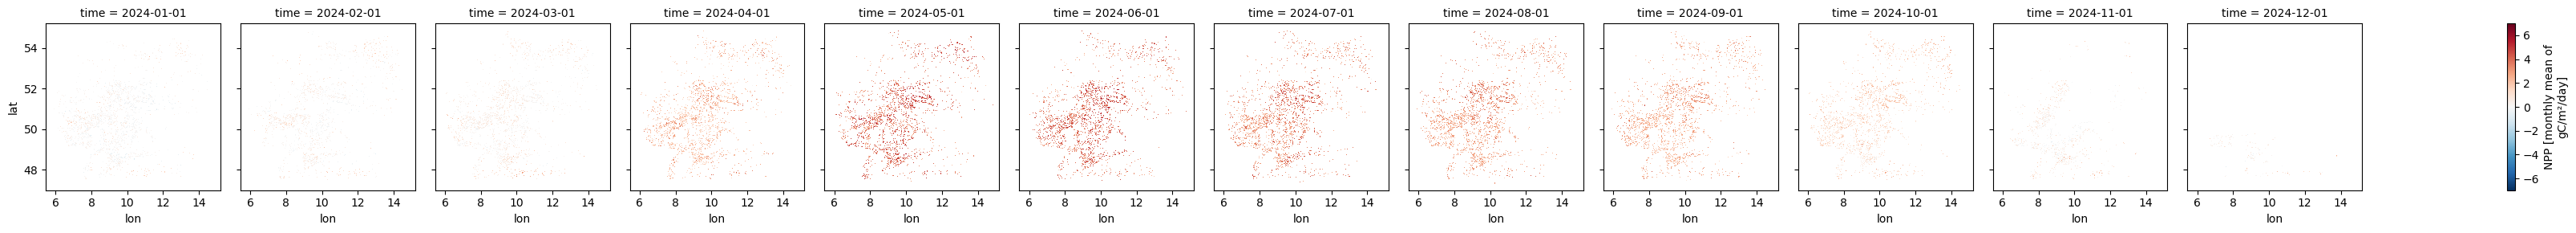

In [22]:
# plot exemplary dataset
npp.NPP.sel(time = slice('2024-01', '2024-12')).plot(col="time")

In [3]:
# open csv datasets
npp_BL = pd.read_csv("./Tables/Spatial_Means/NPP_calc_Monthly_Spatial_Means_BL_notcleaned.csv")
npp_NL = pd.read_csv("./Tables/Spatial_Means/NPP_calc_Monthly_Spatial_Means_NL_notcleaned.csv")

In [4]:
# convert the time values to pandas datetime
npp_BL["time"] = pd.to_datetime(npp_BL["time"])
npp_NL["time"] = pd.to_datetime(npp_NL["time"])

In [5]:
npp_BL = npp_BL.set_index('time')
npp_NL = npp_NL.set_index('time')

In [6]:
# set extreme value in Hesse in 1999 to NA
npp_BL.loc['1999-12-01', 'HE'] = np.nan
npp_NL.loc['1999-12-01', 'HE'] = np.nan

In [7]:
# save cleaned dataframes
npp_BL.to_csv("./Tables/Spatial_Means/NPP_calc_Monthly_Spatial_Means_BL.csv")
npp_NL.to_csv("./Tables/Spatial_Means/NPP_calc_Monthly_Spatial_Means_NL.csv")